##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 理解语言的 Transformer 模型

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://tensorflow.google.cn/tutorials/text/transformer">
    <img src="https://tensorflow.google.cn/images/tf_logo_32px.png" />
    在 tensorflow.google.cn 上查看</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/zh-cn/tutorials/text/transformer.ipynb">
    <img src="https://tensorflow.google.cn/images/colab_logo_32px.png" />
    在 Google Colab 运行</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/zh-cn/tutorials/text/transformer.ipynb">
    <img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png" />
    在 Github 上查看源代码</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/zh-cn/tutorials/text/transformer.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png" />下载此 notebook</a>
  </td>
</table>

Note: 我们的 TensorFlow 社区翻译了这些文档。因为社区翻译是尽力而为， 所以无法保证它们是最准确的，并且反映了最新的
[官方英文文档](https://www.tensorflow.org/?hl=en)。如果您有改进此翻译的建议， 请提交 pull request 到
[tensorflow/docs](https://github.com/tensorflow/docs) GitHub 仓库。要志愿地撰写或者审核译文，请加入
[docs-zh-cn@tensorflow.org Google Group](https://groups.google.com/a/tensorflow.org/forum/#!forum/docs-zh-cn)

本教程训练了一个 <a href="https://arxiv.org/abs/1706.03762" class="external">Transformer 模型</a> 用于将葡萄牙语翻译成英语。这是一个高级示例，假定您具备[文本生成（text generation）](text_generation.ipynb)和 [注意力机制（attention）](nmt_with_attention.ipynb) 的知识。

Transformer 模型的核心思想是*自注意力机制（self-attention）*——能注意输入序列的不同位置以计算该序列的表示的能力。Transformer 创建了多层自注意力层（self-attetion layers）组成的堆栈，下文的*按比缩放的点积注意力（Scaled dot product attention）*和*多头注意力（Multi-head attention）*部分对此进行了说明。

一个 transformer 模型用自注意力层而非 [RNNs](text_classification_rnn.ipynb) 或 [CNNs](../images/intro_to_cnns.ipynb) 来处理变长的输入。这种通用架构有一系列的优势：

* 它不对数据间的时间/空间关系做任何假设。这是处理一组对象（objects）的理想选择（例如，[星际争霸单位（StarCraft units）](https://deepmind.com/blog/alphastar-mastering-real-time-strategy-game-starcraft-ii/#block-8)）。
* 层输出可以并行计算，而非像 RNN 这样的序列计算。
* 远距离项可以影响彼此的输出，而无需经过许多 RNN 步骤或卷积层（例如，参见[场景记忆 Transformer（Scene Memory Transformer）](https://arxiv.org/pdf/1903.03878.pdf)）
* 它能学习长距离的依赖。在许多序列任务中，这是一项挑战。

该架构的缺点是：

* 对于时间序列，一个单位时间的输出是从*整个历史记录*计算的，而非仅从输入和当前的隐含状态计算得到。这*可能*效率较低。   
* 如果输入*确实*有时间/空间的关系，像文本，则必须加入一些位置编码，否则模型将有效地看到一堆单词。

在此 notebook 中训练完模型后，您将能输入葡萄牙语句子，得到其英文翻译。

<img src="https://tensorflow.google.cn/images/tutorials/transformer/attention_map_portuguese.png" width="800" alt="Attention heatmap">

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

## 设置输入流水线（input pipeline）

使用 [TFDS](https://tensorflow.google.cn/datasets) 来导入 [葡萄牙语-英语翻译数据集](https://github.com/neulab/word-embeddings-for-nmt)，该数据集来自于 [TED 演讲开放翻译项目](https://www.ted.com/participate/translate).

该数据集包含来约 50000 条训练样本，1100 条验证样本，以及 2000 条测试样本。

In [3]:
from ipywidgets import IntProgress
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True, as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

In [4]:
#查看一下部分数据
for i,j in train_examples.take(5):
    print("pt is {}, en is {} ".format(i.numpy(),j.numpy()))

pt is b'e quando melhoramos a procura , tiramos a \xc3\xbanica vantagem da impress\xc3\xa3o , que \xc3\xa9 a serendipidade .', en is b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .' 
pt is b'mas e se estes fatores fossem ativos ?', en is b'but what if it were active ?' 
pt is b'mas eles n\xc3\xa3o tinham a curiosidade de me testar .', en is b"but they did n't test for curiosity ." 
pt is b'e esta rebeldia consciente \xc3\xa9 a raz\xc3\xa3o pela qual eu , como agn\xc3\xb3stica , posso ainda ter f\xc3\xa9 .', en is b'and this conscious defiance is why i , as an agnostic , can still have faith .' 
pt is b"`` `` '' podem usar tudo sobre a mesa no meu corpo . ''", en is b'you can use everything on the table on me .' 


从训练数据集创建自定义子词分词器（subwords tokenizer）。

In [5]:
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size=2**13)
 
tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [6]:
sample_string = 'Transformer is awesome.'

tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string: Transformer is awesome.


如果单词不在词典中，则分词器（tokenizer）通过将单词分解为子词来对字符串进行编码。

In [7]:
for ts in tokenized_string:
    print ('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))

7915 ----> T
1248 ----> ran
7946 ----> s
7194 ----> former 
13 ----> is 
2799 ----> awesome
7877 ----> .


In [8]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

将开始和结束标记（token）添加到输入和目标。

In [9]:
def encode(lang1, lang2):
    lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
        lang1.numpy()) + [tokenizer_pt.vocab_size+1]

    lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
        lang2.numpy()) + [tokenizer_en.vocab_size+1]
  
    return lang1, lang2

Note：为了使本示例较小且相对较快，删除长度大于40个标记的样本。

In [10]:
MAX_LENGTH = 40

In [11]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

`.map()` 内部的操作以图模式（graph mode）运行，`.map()` 接收一个不具有 numpy 属性的图张量（graph tensor）。该`分词器（tokenizer）`需要将一个字符串或 Unicode 符号，编码成整数。因此，您需要在 `tf.py_function` 内部运行编码过程，`tf.py_function` 接收一个 eager 张量，该 eager 张量有一个包含字符串值的 numpy 属性。

In [12]:
def tf_encode(pt, en):
    return tf.py_function(encode, [pt, en], [tf.int64, tf.int64])

In [13]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# 将数据集缓存到内存中以加快读取速度。
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(
    BATCH_SIZE, padded_shapes=([-1], [-1]))
# 流水线技术 重叠训练的预处理和模型训练步骤。当加速器正在执行训练步骤 N 时，CPU 开始准备步骤 N + 1 的数据。这样做可以将步骤时间减少到模型训练与抽取转换数据二者所需的最大时间（而不是二者时间总和）。
# 没有流水线技术，CPU 和 GPU/TPU 大部分时间将处于闲置状态:
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(
    BATCH_SIZE, padded_shapes=([-1], [-1]))

In [14]:
pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

(<tf.Tensor: id=207736, shape=(64, 38), dtype=int64, numpy=
 array([[8214,  342, 3032, ...,    0,    0,    0],
        [8214,   95,  198, ...,    0,    0,    0],
        [8214, 4479, 7990, ...,    0,    0,    0],
        ...,
        [8214,  584,   12, ...,    0,    0,    0],
        [8214,   59, 1548, ...,    0,    0,    0],
        [8214,  118,   34, ...,    0,    0,    0]])>,
 <tf.Tensor: id=207737, shape=(64, 40), dtype=int64, numpy=
 array([[8087,   98,   25, ...,    0,    0,    0],
        [8087,   12,   20, ...,    0,    0,    0],
        [8087,   12, 5453, ...,    0,    0,    0],
        ...,
        [8087,   18, 2059, ...,    0,    0,    0],
        [8087,   16, 1436, ...,    0,    0,    0],
        [8087,   15,   57, ...,    0,    0,    0]])>)

## 位置编码（Positional encoding）

因为该模型并不包括任何的循环（recurrence）或卷积，所以模型添加了位置编码，为模型提供一些关于单词在句子中相对位置的信息。

位置编码向量被加到嵌入（embedding）向量中。嵌入表示一个 d 维空间的标记，在 d 维空间中有着相似含义的标记会离彼此更近。但是，嵌入并没有对在一句话中的词的相对位置进行编码。因此，当加上位置编码后，词将基于*它们含义的相似度以及它们在句子中的位置*，在 d 维空间中离彼此更近。

参看 [位置编码](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) 的 notebook 了解更多信息。计算位置编码的公式如下：

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [15]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [16]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
    # 将 sin 应用于数组中的偶数索引（indices）；2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    # 将 cos 应用于数组中的奇数索引；2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

In [17]:
# np.newaxis示例
# a=np.array([1,2,3,4,5])
# b=a[np.newaxis,:]
# print(a.shape,b.shape)
# print(a)
# print(b)

In [18]:
# angle_rads = get_angles(np.arange(5)[:, np.newaxis],
#                           np.arange(16)[np.newaxis, :],
#                           16)
# print(angle_rads.shape)
# print(angle_rads)

(1, 50, 512)


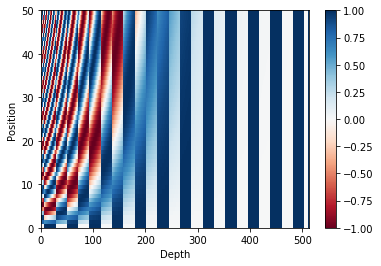

In [19]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## 遮挡（Masking）

遮挡一批序列中所有的填充标记（pad tokens）。这确保了模型不会将填充作为输入。该 mask 表明填充值 `0` 出现的位置：在这些位置 mask 输出 `1`，否则输出 `0`。

In [20]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # 添加额外的维度来将填充加到
    # 注意力对数（logits）。
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [21]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: id=207751, shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

前瞻遮挡（look-ahead mask）用于遮挡一个序列中的后续标记（future tokens）。换句话说，该 mask 表明了不应该使用的条目。

这意味着要预测第三个词，将仅使用第一个和第二个词。与此类似，预测第四个词，仅使用第一个，第二个和第三个词，依此类推。 

In [22]:
def create_look_ahead_mask(size):
    #     tf.linalg.band_part(
    #     input,
    #     num_lower,
    #     num_upper,
    #     name=None
    # )
    # input:输入的张量.
    # num_lower:下三角矩阵保留的副对角线数量，从主对角线开始计算，相当于下三角的带宽。取值为负数时，则全部保留。
    # num_upper:上三角矩阵保留的副对角线数量，从主对角线开始计算，相当于上三角的带宽。取值为负数时，则全部保留。
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [23]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: id=207766, shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## 按比缩放的点积注意力（Scaled dot product attention）

<img src="https://tensorflow.google.cn/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

Transformer 使用的注意力函数有三个输入：Q（请求（query））、K（主键（key））、V（数值（value））。用于计算注意力权重的等式为：

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

点积注意力被缩小了深度的平方根倍。这样做是因为对于较大的深度值，点积的大小会增大，从而推动 softmax 函数往仅有很小的梯度的方向靠拢，导致了一种很硬的（hard）softmax。

例如，假设 `Q` 和 `K` 的均值为0，方差为1。它们的矩阵乘积将有均值为0，方差为 `dk`。因此，*`dk` 的平方根*被用于缩放（而非其他数值），因为，`Q` 和 `K` 的矩阵乘积的均值本应该为 0，方差本应该为1，这样会获得一个更平缓的 softmax。

遮挡（mask）与 -1e9（接近于负无穷）相乘。这样做是因为遮挡与缩放的 Q 和 K 的矩阵乘积相加，并在 softmax 之前立即应用。目标是将这些单元归零，因为 softmax 的较大负数输入在输出中接近于零。

In [24]:
def scaled_dot_product_attention(q, k, v, mask):
    """计算注意力权重。
  q, k, v 必须具有匹配的前置维度。
  k, v 必须有匹配的倒数第二个维度，例如：seq_len_k = seq_len_v。
  虽然 mask 根据其类型（填充或前瞻）有不同的形状，
  但是 mask 必须能进行广播转换以便求和。
  
  参数:
    q: 请求的形状 == (..., seq_len_q, depth)
    k: 主键的形状 == (..., seq_len_k, depth)
    v: 数值的形状 == (..., seq_len_v, depth_v)
    mask: Float 张量，其形状能转换成
          (..., seq_len_q, seq_len_k)。默认为None。
    
  返回值:
    输出，注意力权重
  """

    matmul_qk = tf.matmul(q, k,
                          transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # 缩放 matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # 将 mask 加入到缩放的张量上。
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax 在最后一个轴（seq_len_k）上归一化，因此分数
    # 相加等于1。
    attention_weights = tf.nn.softmax(scaled_attention_logits,
                                      axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

当 softmax 在 K 上进行归一化后，它的值决定了分配到 Q 的重要程度。

输出表示注意力权重和 V（数值）向量的乘积。这确保了要关注的词保持原样，而无关的词将被清除掉。

In [25]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
    print('Attention weights are:')
    print(temp_attn)
    print('Output is:')
    print(temp_out)

In [26]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# 这条 `请求（query）符合第二个`主键（key）`，
# 因此返回了第二个`数值（value）`。
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [27]:
# 这条请求符合重复出现的主键（第三第四个），
# 因此，对所有的相关数值取了平均。
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [28]:
# 这条请求符合第一和第二条主键，
# 因此，对它们的数值去了平均。
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


将所有请求一起*传递*。

In [29]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## 多头注意力（Multi-head attention）

<img src="https://tensorflow.google.cn/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


多头注意力由四部分组成：
*    线性层并分拆成多头。
*    按比缩放的点积注意力。
*    多头及联。
*    最后一层线性层。

每个多头注意力块有三个输入：Q（请求）、K（主键）、V（数值）。这些输入经过线性（Dense）层，并分拆成多头。 

将上面定义的 `scaled_dot_product_attention` 函数应用于每个头（进行了广播（broadcasted）以提高效率）。注意力这步必须使用一个恰当的 mask。然后将每个头的注意力输出连接起来（用`tf.transpose` 和 `tf.reshape`），并放入最后的 `Dense` 层。

Q、K、和 V 被拆分到了多个头，而非单个的注意力头，因为多头允许模型共同注意来自不同表示空间的不同位置的信息。在分拆后，每个头部的维度减少，因此总的计算成本与有着全部维度的单个注意力头相同。

In [30]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """分拆最后一个维度到 (num_heads, depth).
    转置结果使得形状为 (batch_size, num_heads, seq_len, depth)
    """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(
            q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(
            k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(
            v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(
            scaled_attention,
            perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(
            scaled_attention,
            (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(
            concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

创建一个 `MultiHeadAttention` 层进行尝试。在序列中的每个位置 `y`，`MultiHeadAttention` 在序列中的所有其他位置运行所有8个注意力头，在每个位置y，返回一个新的同样长度的向量。

In [31]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## 点式前馈网络（Point wise feed forward network）

点式前馈网络由两层全联接层组成，两层之间有一个 ReLU 激活函数。

In [32]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff,
                              activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

In [33]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## 编码与解码（Encoder and decoder）

<img src="https://tensorflow.google.cn/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

Transformer 模型与标准的[具有注意力机制的序列到序列模型（sequence to sequence with attention model）](nmt_with_attention.ipynb)，遵循相同的一般模式。

* 输入语句经过 `N` 个编码器层，为序列中的每个词/标记生成一个输出。
* 解码器关注编码器的输出以及它自身的输入（自注意力）来预测下一个词。

### 编码器层（Encoder layer）

每个编码器层包括以下子层：

1.   多头注意力（有填充遮挡）
2.   点式前馈网络（Point wise feed forward networks）。

每个子层在其周围有一个残差连接，然后进行层归一化。残差连接有助于避免深度网络中的梯度消失问题。

每个子层的输出是 `LayerNorm(x + Sublayer(x))`。归一化是在 `d_model`（最后一个）维度完成的。Transformer 中有 N 个编码器层。

In [34]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        #     epsilon: Small float added to variance to avoid dividing by zero.
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x,
                                  mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(
            x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(
            out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

In [35]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

### 解码器层（Decoder layer）

每个解码器层包括以下子层：

1.   遮挡的多头注意力（前瞻遮挡和填充遮挡）
2.   多头注意力（用填充遮挡）。V（数值）和 K（主键）接收*编码器输出*作为输入。Q（请求）接收*遮挡的多头注意力子层的输出*。
3.   点式前馈网络

每个子层在其周围有一个残差连接，然后进行层归一化。每个子层的输出是 `LayerNorm(x + Sublayer(x))`。归一化是在 `d_model`（最后一个）维度完成的。

Transformer 中共有 N 个解码器层。

当 Q 接收到解码器的第一个注意力块的输出，并且 K 接收到编码器的输出时，注意力权重表示根据编码器的输出赋予解码器输入的重要性。换一种说法，解码器通过查看编码器输出和对其自身输出的自注意力，预测下一个词。参看按比缩放的点积注意力部分的演示。

In [36]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(
            x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1,
            padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 +
                               out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output +
                               out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [37]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, False, None,
    None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

### 编码器（Encoder）

`编码器` 包括：
1.   输入嵌入（Input Embedding）
2.   位置编码（Positional Encoding）
3.   N 个编码器层（encoder layers）

输入经过嵌入（embedding）后，该嵌入与位置编码相加。该加法结果的输出是编码器层的输入。编码器的输出是解码器的输入。

In [38]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self,
                 num_layers,
                 d_model,
                 num_heads,
                 dff,
                 input_vocab_size,
                 maximum_position_encoding,
                 rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding,
                                                self.d_model)

        self.enc_layers = [
            EncoderLayer(d_model, num_heads, dff, rate)
            for _ in range(num_layers)
        ]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]

        # 将嵌入和位置编码相加。
        x = self.embedding(x)  
        # (batch_size, input_seq_len, d_model)
        #     为什么要乘以embedding size的开方？
        # 猜测是因为embedding matrix的初始化方式是xavier init，这种方式的方差是1/embedding size，
        # 因此乘以embedding size的开方使得embedding matrix的方差是1，在这个scale下可能更有利于embedding matrix的收敛。
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

In [39]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)

sample_encoder_output = sample_encoder(tf.random.uniform((64, 62)), 
                                       training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


### 解码器（Decoder）

`解码器`包括：
1.   输出嵌入（Output Embedding）
2.   位置编码（Positional Encoding）
3.   N 个解码器层（decoder layers）

目标（target）经过一个嵌入后，该嵌入和位置编码相加。该加法结果是解码器层的输入。解码器的输出是最后的线性层的输入。

In [40]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self,
                 num_layers,
                 d_model,
                 num_heads,
                 dff,
                 target_vocab_size,
                 maximum_position_encoding,
                 rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding,
                                                d_model)

        self.dec_layers = [
            DecoderLayer(d_model, num_heads, dff, rate)
            for _ in range(num_layers)
        ]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                   look_ahead_mask,
                                                   padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i + 1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i + 1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [41]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)

output, attn = sample_decoder(tf.random.uniform((64, 26)), 
                              enc_output=sample_encoder_output, 
                              training=False, look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## 创建 Transformer

Transformer 包括编码器，解码器和最后的线性层。解码器的输出是线性层的输入，返回线性层的输出。

In [42]:
class Transformer(tf.keras.Model):
    def __init__(self,
                 num_layers,
                 d_model,
                 num_heads,
                 dff,
                 input_vocab_size,
                 target_vocab_size,
                 pe_input,
                 pe_target,
                 rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                               input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask,
             dec_padding_mask):

        enc_output = self.encoder(
            inp, training,
            enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(tar, enc_output, training,
                                                     look_ahead_mask,
                                                     dec_padding_mask)

        final_output = self.final_layer(
            dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

In [43]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 62))
temp_target = tf.random.uniform((64, 26))

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 26, 8000])

## 配置超参数（hyperparameters）

为了让本示例小且相对较快，已经减小了*num_layers、 d_model 和  dff* 的值。 

Transformer 的基础模型使用的数值为：*num_layers=6*，*d_model = 512*，*dff = 2048*。关于所有其他版本的 Transformer，请查阅[论文](https://arxiv.org/abs/1706.03762)。

Note：通过改变以下数值，您可以获得在许多任务上达到最先进水平的模型。

In [44]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

## 优化器（Optimizer）

根据[论文](https://arxiv.org/abs/1706.03762)中的公式，将 Adam 优化器与自定义的学习速率调度程序（scheduler）配合使用。

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [45]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [46]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5,0,'Train Step')

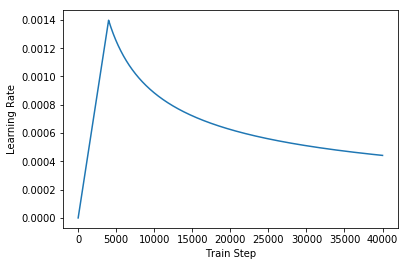

In [47]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## 损失函数与指标（Loss and metrics）

由于目标序列是填充（padded）过的，因此在计算损失函数时，应用填充遮挡非常重要。

In [48]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [49]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [50]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

## 训练与检查点（Training and checkpointing）

In [51]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [52]:
def create_masks(inp, tar):
    # 编码器填充遮挡
    enc_padding_mask = create_padding_mask(inp)

    # 在解码器的第二个注意力模块使用。
    # 该填充遮挡用于遮挡编码器的输出。
    dec_padding_mask = create_padding_mask(inp)

    # 在解码器的第一个注意力模块使用。
    # 用于填充（pad）和遮挡（mask）解码器获取到的输入的后续标记（future tokens）。
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

创建检查点的路径和检查点管理器（manager）。这将用于在每 `n` 个周期（epochs）保存检查点。

In [53]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# 如果检查点存在，则恢复最新的检查点。
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

目标（target）被分成了 tar_inp 和 tar_real。tar_inp 作为输入传递到解码器。`tar_real` 是位移了 1 的同一个输入：在 `tar_inp` 中的每个位置，`tar_real` 包含了应该被预测到的下一个标记（token）。

例如，`sentence` = "SOS A lion in the jungle is sleeping EOS"

`tar_inp` =  "SOS A lion in the jungle is sleeping"

`tar_real` = "A lion in the jungle is sleeping EOS"

Transformer 是一个自回归（auto-regressive）模型：它一次作一个部分的预测，然后使用到目前为止的自身的输出来决定下一步要做什么。

在训练过程中，本示例使用了 teacher-forcing 的方法（就像[文本生成教程](./text_generation.ipynb)中一样）。无论模型在当前时间步骤下预测出什么，teacher-forcing 方法都会将真实的输出传递到下一个时间步骤上。

当 transformer 预测每个词时，*自注意力（self-attention）*功能使它能够查看输入序列中前面的单词，从而更好地预测下一个单词。

为了防止模型在期望的输出上达到峰值，模型使用了前瞻遮挡（look-ahead mask）。

In [54]:
EPOCHS = 5

In [55]:
# 该 @tf.function 将追踪-编译 train_step 到 TF 图中，以便更快地
# 执行。该函数专用于参数张量的精确形状。为了避免由于可变序列长度或可变
# 批次大小（最后一批次较小）导致的再追踪，使用 input_signature 指定
# 更多的通用形状。

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, True, enc_padding_mask,
                                     combined_mask, dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar_real, predictions)

葡萄牙语作为输入语言，英语为目标语言。

In [56]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    # inp -> portuguese, tar -> english
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        if batch % 50 == 0:
            print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
                epoch + 1, batch, train_loss.result(),
                train_accuracy.result()))

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print('Saving checkpoint for epoch {} at {}'.format(
            epoch + 1, ckpt_save_path))

    print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(
        epoch + 1, train_loss.result(), train_accuracy.result()))

    print('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.3110 Accuracy 0.0000
Epoch 1 Batch 50 Loss 4.2296 Accuracy 0.0007
Epoch 1 Batch 100 Loss 4.1944 Accuracy 0.0114
Epoch 1 Batch 150 Loss 4.1565 Accuracy 0.0167
Epoch 1 Batch 200 Loss 4.0987 Accuracy 0.0194
Epoch 1 Batch 250 Loss 4.0298 Accuracy 0.0222
Epoch 1 Batch 300 Loss 3.9390 Accuracy 0.0262
Epoch 1 Batch 350 Loss 3.8438 Accuracy 0.0296
Epoch 1 Batch 400 Loss 3.7598 Accuracy 0.0322
Epoch 1 Batch 450 Loss 3.6778 Accuracy 0.0348
Epoch 1 Batch 500 Loss 3.6052 Accuracy 0.0377
Epoch 1 Batch 550 Loss 3.5494 Accuracy 0.0410
Epoch 1 Batch 600 Loss 3.4873 Accuracy 0.0446
Epoch 1 Batch 650 Loss 3.4307 Accuracy 0.0480
Epoch 1 Batch 700 Loss 3.3753 Accuracy 0.0515
Epoch 1 Loss 3.3741 Accuracy 0.0516
Time taken for 1 epoch: 899.3856389522552 secs

Epoch 2 Batch 0 Loss 2.5529 Accuracy 0.1032
Epoch 2 Batch 50 Loss 2.5547 Accuracy 0.1021
Epoch 2 Batch 100 Loss 2.5329 Accuracy 0.1045
Epoch 2 Batch 150 Loss 2.5108 Accuracy 0.1065
Epoch 2 Batch 200 Loss 2.4919 Accuracy 0.1088
Ep

## 评估（Evaluate）

以下步骤用于评估：

* 用葡萄牙语分词器（`tokenizer_pt`）编码输入语句。此外，添加开始和结束标记，这样输入就与模型训练的内容相同。这是编码器输入。
* 解码器输入为 `start token == tokenizer_en.vocab_size`。
* 计算填充遮挡和前瞻遮挡。
* `解码器`通过查看`编码器输出`和它自身的输出（自注意力）给出预测。
* 选择最后一个词并计算它的 argmax。
* 将预测的词连接到解码器输入，然后传递给解码器。
* 在这种方法中，解码器根据它预测的之前的词预测下一个。

Note：这里使用的模型具有较小的能力以保持相对较快，因此预测可能不太正确。要复现论文中的结果，请使用全部数据集，并通过修改上述超参数来使用基础 transformer 模型或者 transformer XL。

In [57]:
def evaluate(inp_sentence):
    start_token = [tokenizer_pt.vocab_size]
    end_token = [tokenizer_pt.vocab_size + 1]

    # 输入语句是葡萄牙语，增加开始和结束标记
    inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)

    # 因为目标是英语，输入 transformer 的第一个词应该是
    # 英语的开始标记。
    decoder_input = [tokenizer_en.vocab_size]
    output = tf.expand_dims(decoder_input, 0)

    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input, output,
                                                     False, enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)

        # 从 seq_len 维度选择最后一个词
        predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 如果 predicted_id 等于结束标记，就返回结果
        if predicted_id == tokenizer_en.vocab_size + 1:
            return tf.squeeze(output, axis=0), attention_weights

        # 连接 predicted_id 与输出，作为解码器的输入传递到解码器。
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [58]:
def plot_attention_weights(attention, sentence, result, layer):
    fig = plt.figure(figsize=(16, 8))

    sentence = tokenizer_pt.encode(sentence)

    attention = tf.squeeze(attention[layer], axis=0)

    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head + 1)

        # 画出注意力权重
        ax.matshow(attention[head][:-1, :], cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(sentence) + 2))
        ax.set_yticks(range(len(result)))

        ax.set_ylim(len(result) - 1.5, -0.5)

        ax.set_xticklabels(['<start>'] +
                           [tokenizer_pt.decode([i])
                            for i in sentence] + ['<end>'],
                           fontdict=fontdict,
                           rotation=90)

        ax.set_yticklabels([
            tokenizer_en.decode([i])
            for i in result if i < tokenizer_en.vocab_size
        ],
                           fontdict=fontdict)

        ax.set_xlabel('Head {}'.format(head + 1))

    plt.tight_layout()
    plt.show()

In [59]:
def translate(sentence, plot=''):
    result, attention_weights = evaluate(sentence)

    predicted_sentence = tokenizer_en.decode(
        [i for i in result if i < tokenizer_en.vocab_size])

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))

    if plot:
        plot_attention_weights(attention_weights, sentence, result, plot)

In [60]:
translate("este é um problema que temos que resolver.")
print ("Real translation: this is a problem we have to solve .")

Input: este é um problema que temos que resolver.
Predicted translation: this is a problem that we have to solve this .
Real translation: this is a problem we have to solve .


In [61]:
translate("os meus vizinhos ouviram sobre esta ideia.")
print ("Real translation: and my neighboring homes heard about this idea .")

Input: os meus vizinhos ouviram sobre esta ideia.
Predicted translation: my children have to have this idea about this .
Real translation: and my neighboring homes heard about this idea .


In [62]:
translate("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.")
print ("Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .")

Input: vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Predicted translation: so i 'll give you very little lot of some lot of some of things that happens .
Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .


您可以为 `plot` 参数传递不同的层和解码器的注意力模块。

Input: este é o primeiro livro que eu fiz.
Predicted translation: this is the first book that i did n't do .


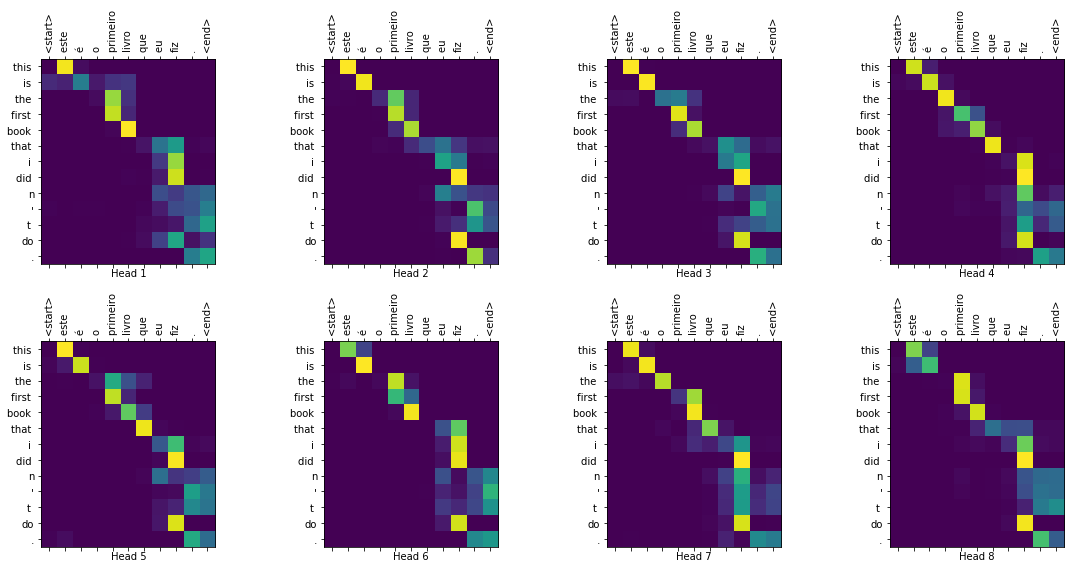

Real translation: this is the first book i've ever done.


In [63]:
translate("este é o primeiro livro que eu fiz.", plot='decoder_layer4_block2')
print ("Real translation: this is the first book i've ever done.")

## 总结

在本教程中，您已经学习了位置编码，多头注意力，遮挡的重要性以及如何创建一个 transformer。

尝试使用一个不同的数据集来训练 transformer。您可也可以通过修改上述的超参数来创建基础 transformer 或者 transformer XL。您也可以使用这里定义的层来创建 [BERT](https://arxiv.org/abs/1810.04805) 并训练最先进的模型。此外，您可以实现 beam search 得到更好的预测。